In [1]:
import sys
sys.path.append('..')
from experiments import perform_gradcam, perform_lrp_captum
from internal_utils import preprocess_images, condense_to_heatmap, blur_image_batch, add_random_noise_batch, get_data_imagenette, get_teacher_model, get_CIFAR10_dataloader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torchvision.transforms.functional as TF

def visualise_panel_image(image, model, kernel_size_min, kernel_size_max, noise_level_min, noise_level_max, method, label):
    """Visualise the panel of images for the model."""
    # Assume the image tensor is already in batch format, if not, unsqueeze it
    if image.dim() == 3:
        image = image.unsqueeze(0)
    
    original_image = image
    # treated images
    blurred_small = blur_image_batch(image, kernel_size_min)
    blurred_large = blur_image_batch(image, kernel_size_max)
    noisy_small = add_random_noise_batch(image, noise_level_min)
    noisy_large = add_random_noise_batch(image, noise_level_max)
    
    # model outputs
    original_heatmap = condense_to_heatmap(method(preprocess_images(image), label, model)).detach()
    blurred_small_heatmap = condense_to_heatmap(method(preprocess_images(blurred_small), label, model)).detach()
    blurred_large_heatmap = condense_to_heatmap(method(preprocess_images(blurred_large),label,  model)).detach()
    noisy_small_heatmap = condense_to_heatmap( method(preprocess_images(noisy_small), label, model)).detach()
    noisy_large_heatmap = condense_to_heatmap(method(preprocess_images(noisy_large), label, model)).detach()
    
    # Display images
    fig, ax = plt.subplots(2, 5, figsize=(15, 5))
    ax[0][0].imshow(original_image.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[0][0].set_title('Original Image')
    ax[0][1].imshow(blurred_small.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[0][1].set_title('Small Blurred Image')
    ax[0][2].imshow(blurred_large.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[0][2].set_title('Large Blurred Image')
    ax[0][3].imshow(noisy_small.squeeze().detach().permute(1, 2, 0).cpu().numpy())  # Example visualization
    ax[0][3].set_title('Small Noisy Image')
    ax[0][4].imshow(noisy_large.squeeze().detach().permute(1, 2, 0).cpu().numpy())  # Example visualization
    ax[0][4].set_title('Large Noisy Image')
    
    ax[1][0].imshow(original_heatmap.squeeze(0), cmap='seismic')
    ax[1][0].set_title('Original Heatmap')
    ax[1][1].imshow(blurred_small_heatmap.squeeze(0), cmap='seismic')
    ax[1][1].set_title('Small Blurred Heatmap')
    ax[1][2].imshow(blurred_large_heatmap.squeeze(0), cmap='seismic')
    ax[1][2].set_title('Large Blurred Heatmap')
    ax[1][3].imshow(noisy_small_heatmap.squeeze(0), cmap ='seismic')  # Example visualization
    ax[1][3].set_title('Small Noisy Heatmap')
    ax[1][4].imshow(noisy_large_heatmap.squeeze(0), cmap ='seismic')  # Example visualization
    ax[1][4].set_title('Large Noisy Heatmap')
    
    for i in ax:
        for j in i:
            j.axis('off')
    plt.show()

In [2]:
from experiments import WrapperNet, WrapperNetContrastive
import torch
from internal_utils import update_dictionary_patch
from baselines.trainVggBaselineForCIFAR10.vgg import vgg11

def get_teacher_model(teacher_checkpoint_path):
    checkpoint = torch.load(teacher_checkpoint_path)
    # assume teacher model is vgg11 for now
    teacher = vgg11()
    try: 
        checkpoint = update_dictionary_patch(checkpoint)
        teacher.load_state_dict(checkpoint['new_state_dict'])
    except:
        print('Incorrect patch specified')
    return teacher
data = get_CIFAR10_dataloader()
input_images, labels = next(iter(data))
teacher_model = WrapperNet(get_teacher_model("/home/charleshiggins/RL-LRP/baselines/trainVggBaselineForCIFAR10/save_vgg11/checkpoint_299.tar"), hybrid_loss=True)
# define params
learner_model = WrapperNet(vgg11(), hybrid_loss=True)

/var/tmp/ipykernel_1284712/1561470782.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(teacher_checkpoint_path)


In [3]:
input_images, labels = next(iter(data))

In [4]:
two_images, two_labels = input_images[12:14], labels[12:14]


In [5]:
two_labels.shape

torch.Size([2])

normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0000001192092896
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0000001192092896
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24468455..1.2855012].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5525924..2.4456787].


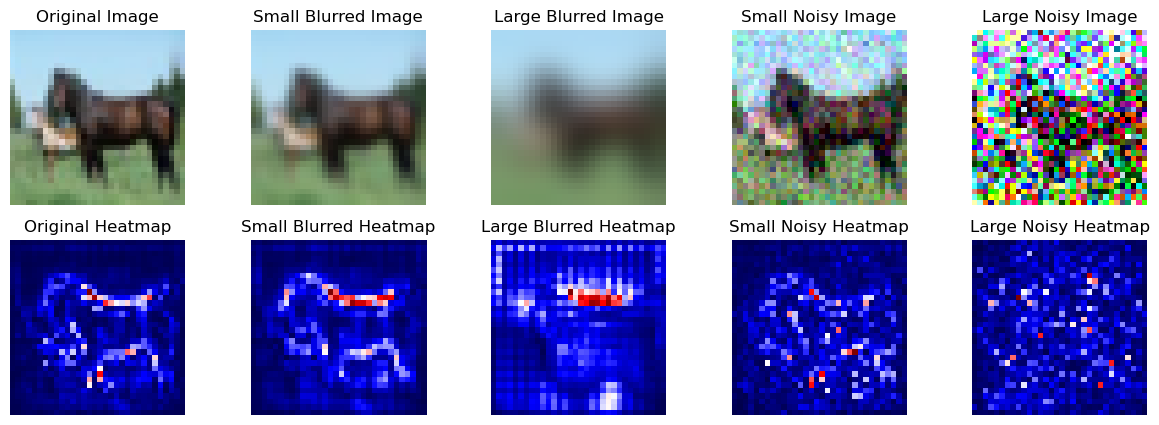

In [6]:
from experiments import perform_lrp_plain
visualise_panel_image(two_images[0].unsqueeze(0), teacher_model, 3, 15, 0.1, 0.5, perform_lrp_plain, two_labels[0].unsqueeze(0))

normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0000001192092896
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 0.9999999403953552


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25606382..1.1827959].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5114573..2.1085892].


normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0


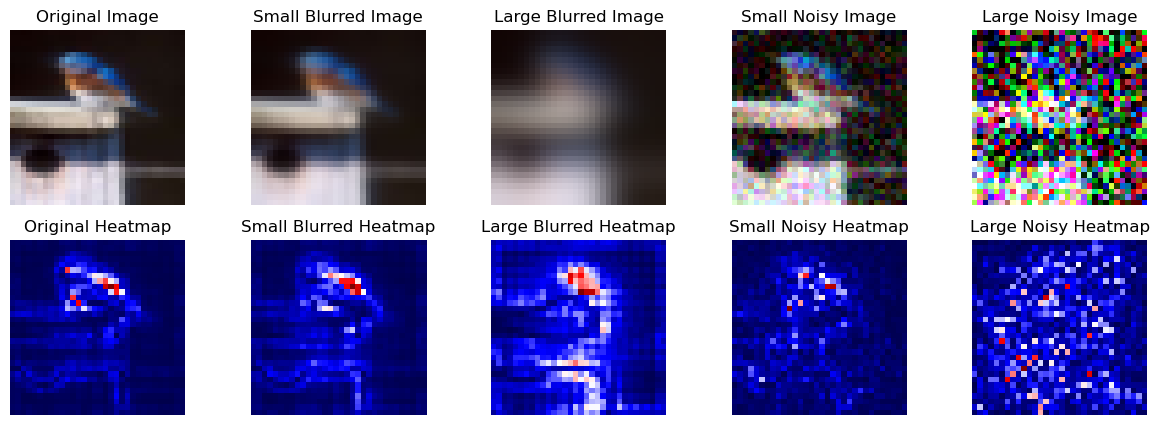

In [7]:
visualise_panel_image(two_images[1].unsqueeze(0), teacher_model, 3, 15, 0.1, 0.5, perform_lrp_plain, two_labels[1].unsqueeze(0))

normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 0.9999999403953552
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 0.9999999403953552


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26270238..1.2171639].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2706..2.2609706].


normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0000001192092896


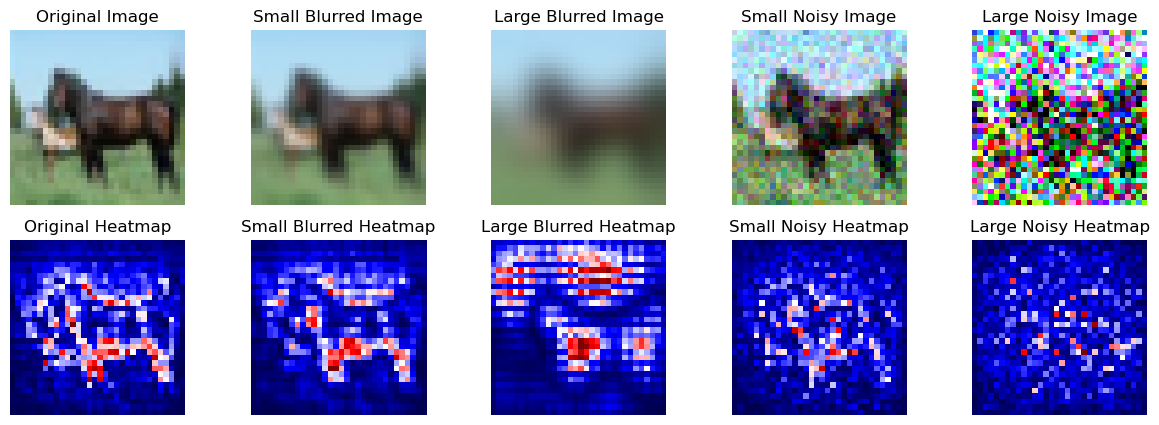

In [8]:
visualise_panel_image(two_images[0].unsqueeze(0), learner_model, 3, 15, 0.1, 0.5, perform_lrp_plain, two_labels[0].unsqueeze(0))

In [9]:
pp_images = preprocess_images(two_images)


In [10]:
print(f"The target tensor should be: {two_labels}")

The target tensor should be: tensor([7, 2])


In [11]:
output, heatmap = learner_model(pp_images)
output_target, heatmap_target = teacher_model(pp_images)

In [12]:
import torch.nn as nn
class CosineDistanceLoss(torch.nn.Module):
    def __init__(self):
        super(CosineDistanceLoss, self).__init__()

    def forward(self, input1, input2):
        # Flatten the images: shape from [b, 1, 28, 28] to [b, 784]
        input1_flat = input1.view(input1.size(0), -1)
        input2_flat = input2.view(input2.size(0), -1)
        
        # Compute cosine similarity, then convert to cosine distance
        cosine_sim = F.cosine_similarity(input1_flat, input2_flat)
        cosine_dist = 1 - cosine_sim
        
        # Calculate the mean of the cosine distances
        loss = cosine_dist.mean()
        # loss = F.mse_loss(input1_flat, input2_flat)
        return loss
    

# Define SSIM loss (we'll minimize 1 - SSIM)
class SSIMLoss(torch.nn.Module):
    def __init__(self, data_range=1.0, size_average=True, channel=3):
        super(SSIMLoss, self).__init__()
        self.ssim_module = SSIM(data_range=data_range, size_average=size_average, channel=channel)
    
    def forward(self, img1, img2):
        ssim_value = self.ssim_module(img1, img2)
        return 1 - ssim_value
    
def remove_grad_for_all_but_last_layer(learner_model, optimizer):
    for name, module in learner_model.model.named_modules():
        if not isinstance(module, nn.Sequential) \
        and not isinstance(module, WrapperNet) \
        and not len(list(module.children())) > 0 \
            and type(module) not in [nn.ReLU, nn.MaxPool2d, nn.AdaptiveAvgPool2d, nn.LogSoftmax, nn.Dropout]:
            # print(name)
            # print(module)
            # print("####################### \n")
            if "classifier" not in name:
                print(f"removing grad from: {name}")
                for param in module.parameters():
                    param.requires_grad = False
            else:
                print(f"Grad will continue for {name}")
    optimizer = torch.optim.SGD(learner_model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
    return learner_model, optimizer

In [13]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
optimizer = torch.optim.SGD(learner_model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
cos_loss = CosineDistanceLoss()
ssim_loss = SSIMLoss()
print("initial model output: ", output)
with torch.no_grad():
    _, teacher_heatmap = teacher_model(pp_images)
for i in range(0, 500):
    model_out, model_heatmap = learner_model(pp_images, two_labels)
    optimizer.zero_grad()
    loss = ssim_loss(model_heatmap, teacher_heatmap)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(learner_model.parameters(), 1)
    optimizer.step()
    # scheduler.step()
    print(f"model out, iteration {i}: {model_out[:,two_labels]} \t model argmax: {torch.argmax(model_out, dim=1)} \t loss: {loss.float()}")
    if i == 100:
        learner_model, optimizer = remove_grad_for_all_but_last_layer(learner_model, optimizer)
        print("REMOVED GRADIENTS")

initial model output:  tensor([[-0.0288,  0.0552, -0.0189, -0.0100, -0.0169, -0.0062, -0.0512, -0.0357,
         -0.0149, -0.0054],
        [-0.0303,  0.0850, -0.0071, -0.0386, -0.0035,  0.0217, -0.0837, -0.0091,
         -0.0201,  0.0125]], grad_fn=<AddmmBackward0>)
model out, iteration 0: tensor([[-0.0129,  0.0003],
        [ 0.0024, -0.0233]], grad_fn=<IndexBackward0>) 	 model argmax: tensor([1, 1]) 	 loss: 0.9002053141593933
model out, iteration 1: tensor([[ 0.0388, -0.0163],
        [ 0.0203, -0.0189]], grad_fn=<IndexBackward0>) 	 model argmax: tensor([1, 1]) 	 loss: 0.7957083582878113
model out, iteration 2: tensor([[0.0735, 0.0024],
        [0.0982, 0.0266]], grad_fn=<IndexBackward0>) 	 model argmax: tensor([7, 7]) 	 loss: 0.7123078107833862
model out, iteration 3: tensor([[0.1578, 0.0790],
        [0.1650, 0.0578]], grad_fn=<IndexBackward0>) 	 model argmax: tensor([7, 7]) 	 loss: 0.5136774778366089
model out, iteration 4: tensor([[0.1861, 0.0982],
        [0.1880, 0.1013]], gra

In [14]:
model_out

tensor([[-0.2897, -0.4497,  5.0134,  0.0459, -0.1507, -0.5999, -0.5162,  4.2688,
          0.3364,  0.3106],
        [-0.3101, -0.5210,  5.3243, -0.1767, -0.2789, -0.5963, -0.5335,  4.3381,
          0.4271,  0.3879]], grad_fn=<AddmmBackward0>)

normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 0.9999999403953552
normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 0.9999998807907104


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19166832..1.2828742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6818441..2.5480883].


normalized_tensor shape: torch.Size([1, 3, 32, 32])
normalized_tensor sum: 1.0000001192092896


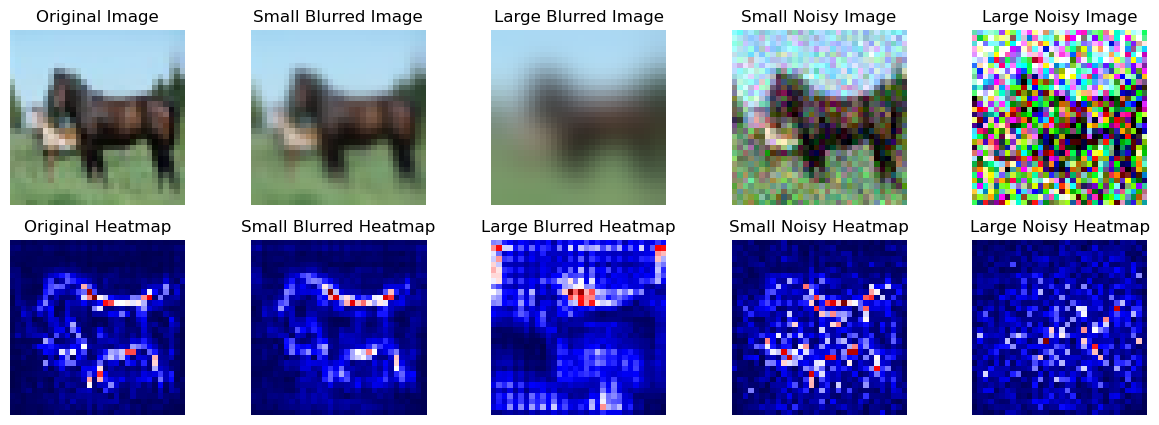

In [15]:
visualise_panel_image(two_images[0].unsqueeze(0), learner_model, 3, 15, 0.1, 0.5, perform_lrp_plain, two_labels[0].unsqueeze(0))


In [16]:
learner_model

WrapperNet(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel_si

In [17]:
import torch.nn as nn
